<a href="https://colab.research.google.com/github/Epilef86/Clusterizacao_Pratica/blob/main/Lojista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

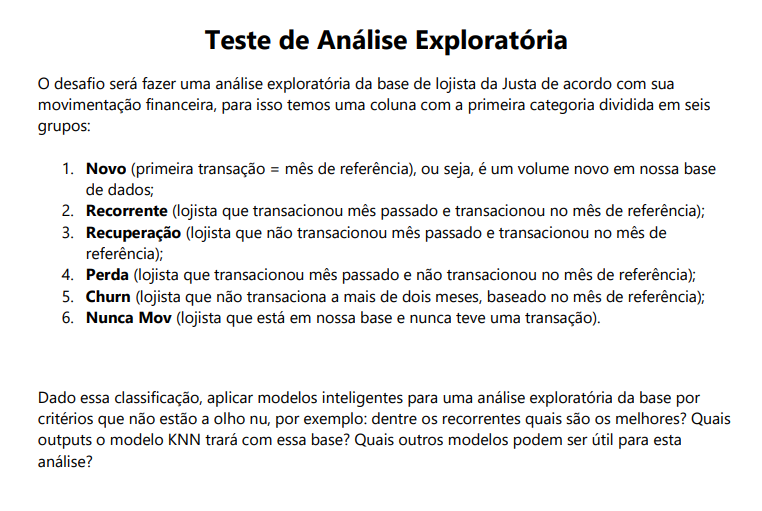

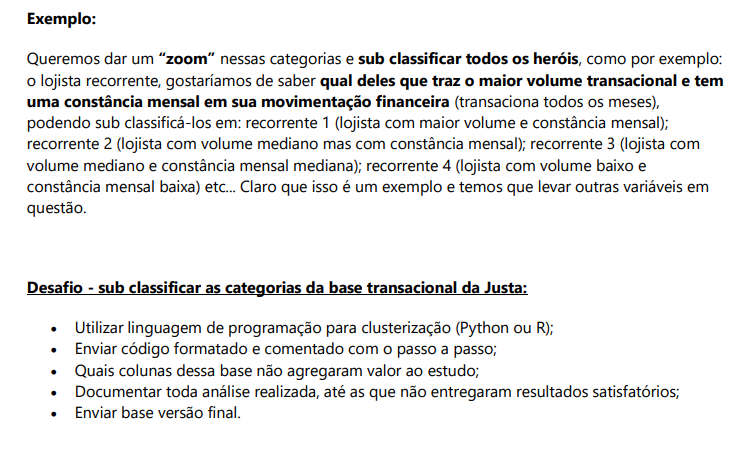

Instalar a biblioteca sidetable serve pra facilitar a contagem dos valores e mostrar os valores ausentes (missing values)

In [ ]:
%%capture
%pip install sidetable

Bibliotecas de Data Wrangling

In [ ]:
# Data wrangling
import numpy as np
import pandas as pd
import sidetable
from datetime import datetime

Bibliotecas de visualização de dados

In [ ]:
# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

Importando bibliotecas de machine learning

In [ ]:
## -- Machine learning -- ##

from sklearn.preprocessing import StandardScaler, scale, PowerTransformer
from yellowbrick.cluster import kelbow_visualizer, SilhouetteVisualizer, KElbowVisualizer, silhouette_visualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

A célula abaixo vai estar configurando as figuras, deixando os gráficos estaticamente mais atraentes

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

Data Understanding

In [ ]:
df_lojista = pd.read_excel('/content/base_analise_exploratoria.xlsx')

df_lojista.head()

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0
2,90,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,21.0
3,94,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,NaN
4,94,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,NaN


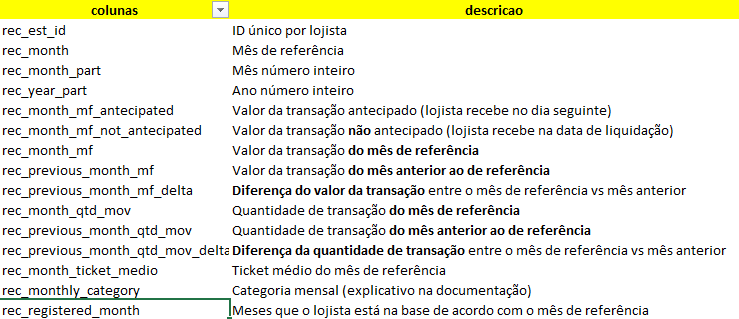

Data Cleaning

In [ ]:
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205363 entries, 0 to 205362
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   rec_est_id                        205363 non-null  int64         
 1   rec_month                         205363 non-null  datetime64[ns]
 2   rec_month_part                    205363 non-null  int64         
 3   rec_year_part                     205363 non-null  int64         
 4   rec_month_mf_antecipated          205363 non-null  float64       
 5   rec_month_mf_not_antecipated      205363 non-null  float64       
 6   rec_month_mf                      205363 non-null  float64       
 7   rec_previous_month_mf             205363 non-null  float64       
 8   rec_previous_month_mf_delta       205363 non-null  float64       
 9   rec_month_qtd_mov                 205363 non-null  int64         
 10  rec_previous_month_qtd_mov      

Mais a frente irei mudar a coluna "rec_registered_month" de float para int. Também se verifica que existem valores nulos nela.

Analisando a coluna "rec_monthly_category" pra saber o porquê que ela está como object/string

In [ ]:
df_lojista.rec_monthly_category.sort_values()

0               Churn
107060          Churn
107059          Churn
107058          Churn
107057          Churn
             ...     
120544    Recuperação
120561    Recuperação
70135     Recuperação
45498     Recuperação
26462     Recuperação
Name: rec_monthly_category, Length: 205363, dtype: object

In [ ]:
#Fiz só pra testar filtrando apenas valores que contenha 'Recuperação'
#df_lojista[(df_lojista['rec_monthly_category'] == 'Recuperação')]

In [ ]:
#Verificando a quantidade de cada categoria dos lojistas.

df_lojista.rec_monthly_category.value_counts()

Churn          103883
Nunca Mov       77845
Recorrente      13494
Perda            5728
Novo             2917
Recuperação      1496
Name: rec_monthly_category, dtype: int64

Verificando o percentual de cada categoria via gráfico

<Axes: >

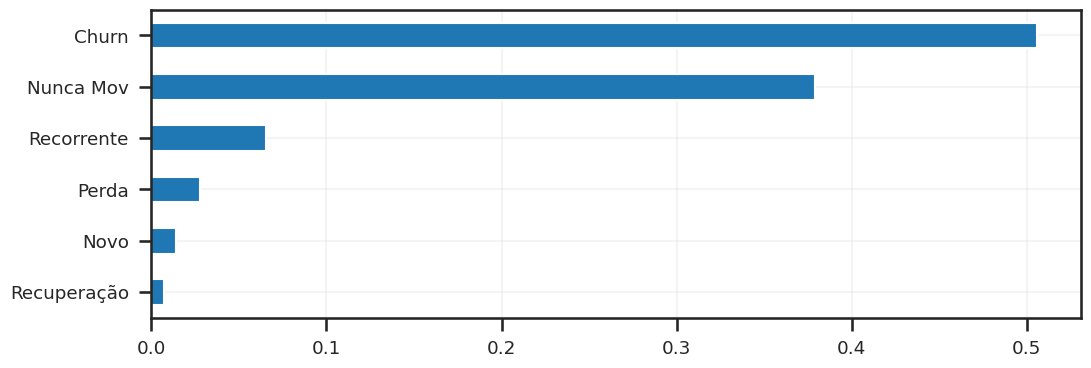

In [ ]:
df_lojista['rec_monthly_category'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,4))

Descobrindo a primeira e última data

In [ ]:
df_lojista.rec_month.agg(['min','max'])

min   2022-01-01
max   2023-02-01
Name: rec_month, dtype: datetime64[ns]

Criando duas variáveis diferentes para armazenar os dados do ano de 2022 e do ano de 2023.

In [ ]:
df_2022 = df_lojista[df_lojista['rec_month'].dt.year == 2022]
df_2023 = df_lojista[df_lojista['rec_month'].dt.year == 2023]

Agrupando os dados de cada ano pela nova coluna MesAno e somando os valores da coluna de faturamento para cada mês:

In [ ]:
df_agg_2022 = df_2022.groupby('rec_month_part')['rec_month_mf'].sum().reset_index()
df_agg_2023 = df_2023.groupby('rec_month_part')['rec_month_mf'].sum().reset_index()

Criando dois gráficos de barras separados, um para o ano de 2022 e outro para o ano de 2023. Cada gráfico mostrará a soma mensal do faturamento para cada mês do respectivo ano.

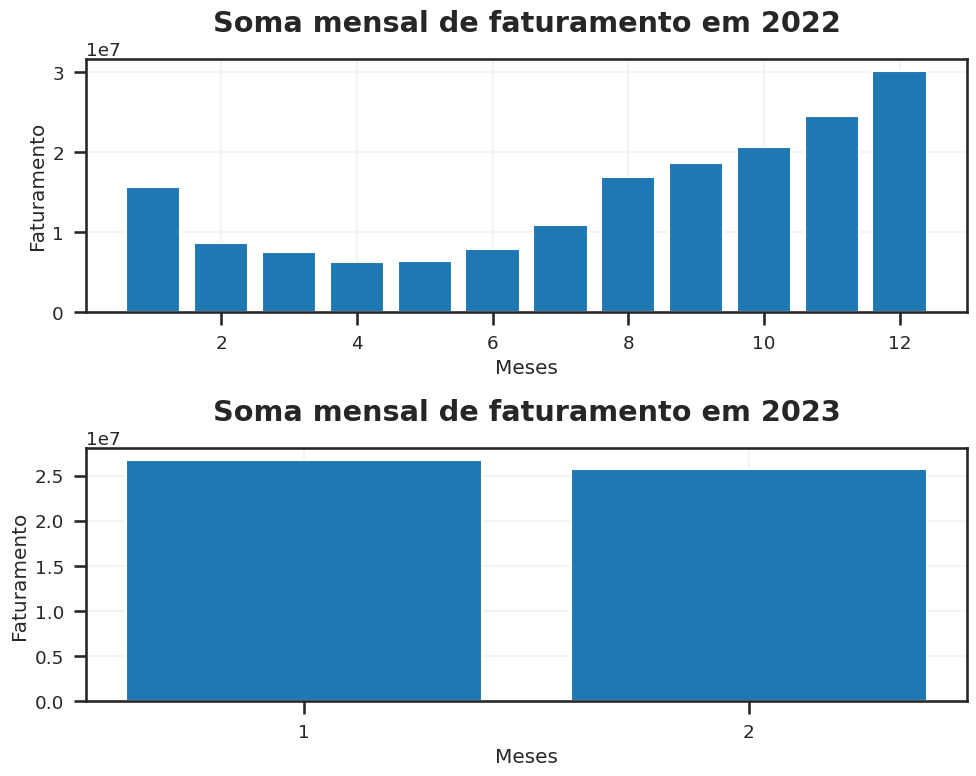

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.bar(df_agg_2022['rec_month_part'], df_agg_2022['rec_month_mf'])
ax1.set_title('Soma mensal de faturamento em 2022')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Faturamento')
# Define as etiquetas do eixo x como o número inteiro correspondente a cada mês
plt.xticks(range(1, 13), range(1, 13))

ax2.bar(df_agg_2023['rec_month_part'], df_agg_2023['rec_month_mf'])
ax2.set_title('Soma mensal de faturamento em 2023')
ax2.set_xlabel('Meses')
ax2.set_ylabel('Faturamento')
# Define as etiquetas do eixo x como o número inteiro correspondente a cada mês
plt.xticks(range(1, 3), range(1, 3))

plt.tight_layout()
plt.show()

Criando um filtro apenas dos grupos que fizeram transações no mês atual da coluna "rec_monthly_category" 

In [ ]:
# Filtra apenas nas linhas aonde teve transações do mês atual
filtro = df_lojista.loc[
    (df_lojista['rec_monthly_category'] == 'Novo') | (df_lojista['rec_monthly_category'] == 'Recorrente') |
    (df_lojista['rec_monthly_category'] == 'Recuperação')
    ]

Analisando essas 02 colunas abaixo, pois é importante saber se a empresa tem caixa pra repor o mês atual, ou seja, consiga pagar todos os custos operacionais, caso se tenha muitos valores não antecipados.

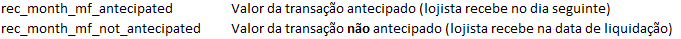

In [ ]:
filtro[['rec_month_mf_antecipated','rec_month_mf_not_antecipated']].describe()

,rec_month_mf_antecipated,rec_month_mf_not_antecipated
count,17907.000000,17907.000000
mean,9619.058847,3034.405067
std,34168.452969,18515.849015
min,0.000000,0.000000
25%,53.000000,0.000000
50%,1800.000000,0.000000
75%,8305.500000,0.000000
max,814475.400000,588157.520000


O desvio é o quanto o valor é disperso da média. Quanto maior o desvio padrão a média não explica tão bem, do inverso também. Nesse caso o desvio padrão foi muito alto devido a outliers

<Axes: >

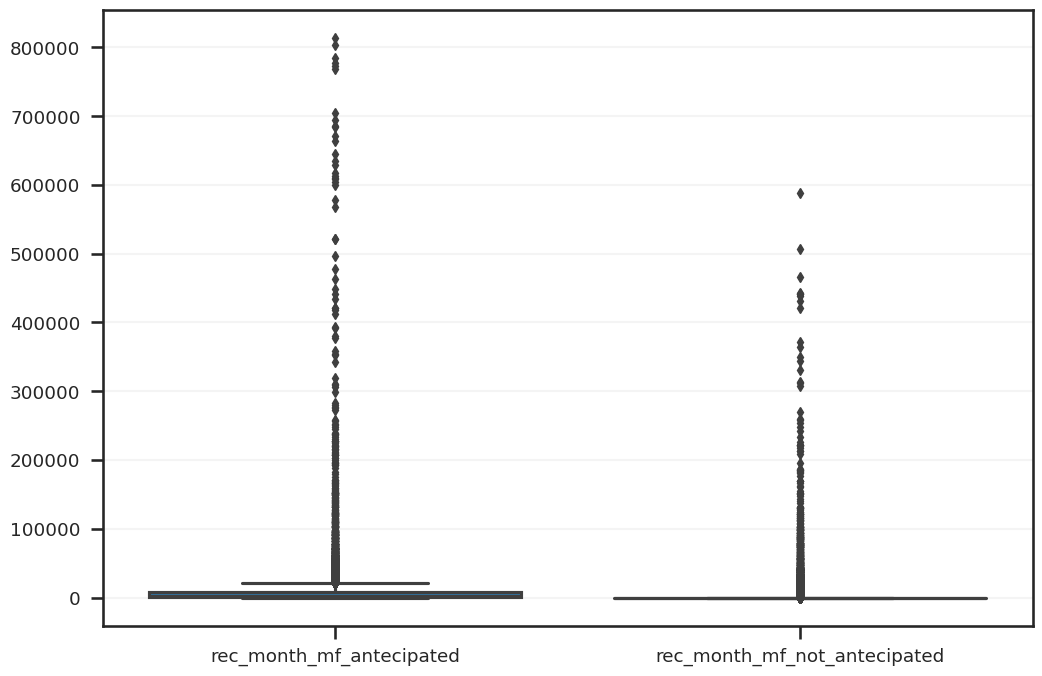

In [ ]:
sns.boxplot(filtro[['rec_month_mf_antecipated','rec_month_mf_not_antecipated']])

O eixo y são os valores das transações, verifica-se muitos outliers

In [ ]:
# Filtrando um cliente aleatório com o ID igual a 44 pra fazer uma análise da distribuição dos dados
df_lojista[df_lojista['rec_est_id'] == 44]



,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0
21887,44,2023-02-01,2,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,58.0
41718,44,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45.0
41719,44,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,50.0
52794,44,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47.0
74764,44,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,49.0
90143,44,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,55.0
95024,44,2023-01-01,1,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,57.0
113813,44,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,51.0


Ordenando as datas e o ID ao mesmo tempo

In [ ]:
df_lojista.sort_values(['rec_est_id', 'rec_month'], ascending=[True, True], inplace=True)

Verificando novamente esse cliente, que foi um cliente aleatório

In [ ]:
# Filtra o cliente com o ID igual a 44
df_lojista[df_lojista['rec_est_id'] == 44]


,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
41718,44,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45.0
170187,44,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46.0
52794,44,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47.0
192775,44,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48.0
74764,44,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,49.0
41719,44,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,50.0
113813,44,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,51.0
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
183228,44,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,53.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0


Observe que o cliente teve seu primeiro registro há 45 meses atrás contados a partir de janeiro de 2022, isso pode ser visto na coluna "rec_registered_month" logo o dataset disponibilizado pela autor está incompleto, possuindo dados apenas a partir de janeiro de 2022. 

Vou excluir os clientes que TODOS os itens são do mesmo tipo "Churn" ou apenas "Nunca Mov" porque eles não fizeram transações nesses períodos. O de "Perda" não vou excluir porque ele só não movimentou um mês antes do mês de referência, porém fez transações.

In [ ]:
# Identificar os IDs que possuem única e exclusivamente o valor 'Churn' na coluna de rec_registered_month
id_to_remove = df_lojista.groupby('rec_est_id')['rec_monthly_category'].unique().apply(lambda x: len(x) == 1 and 'Churn' in x).loc[lambda x: x].index

# Nesse código, é feito um filtro selecionando os ids que possuem apenas um valor único como categoria e essa valor é justamente 'Churn'.

# Remover as linhas desses IDs do dataframe
df_lojista = df_lojista[~df_lojista['rec_est_id'].isin(id_to_remove)]

In [ ]:
# Verificando se o cliente com o ID igual a 44 ainda está no dataset
df_lojista[df_lojista['rec_est_id'] == 44]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month


Excluindo os clientes aonde todos os itens são "Nunca Mov"

In [ ]:
# Identificar os IDs que possuem única e exclusivamente o valor 'Churn' na coluna de rec_registered_month
id_to_remove = df_lojista.groupby('rec_est_id')['rec_monthly_category'].unique().apply(lambda x: len(x) == 1 and 'Nunca Mov' in x).loc[lambda x: x].index

# Nesse código, é feito um filtro selecionando os ids que possuem apenas um valor único como categoria e essa valor é justamente 'Churn'.

# Remover as linhas desses IDs do dataframe
df_lojista = df_lojista[~df_lojista['rec_est_id'].isin(id_to_remove)]

Verificando quantos dados existem no meu dataset

In [ ]:
df_lojista.shape

(63320, 15)

Verificando se tem valores nulos

In [ ]:
df_lojista.isna().sum().sort_values(ascending=False)

rec_est_id                          0
rec_month                           0
rec_month_part                      0
rec_year_part                       0
rec_month_mf_antecipated            0
rec_month_mf_not_antecipated        0
rec_month_mf                        0
rec_previous_month_mf               0
rec_previous_month_mf_delta         0
rec_month_qtd_mov                   0
rec_previous_month_qtd_mov          0
rec_previous_month_qtd_mov_delta    0
rec_month_ticket_medio              0
rec_monthly_category                0
rec_registered_month                0
dtype: int64

Verificando se têm linhas duplicadas no dataset

In [ ]:
df_lojista.duplicated().sum()

0

In [ ]:
# converter a coluna "rec_registered_month" para int
df_lojista['rec_registered_month'] = df_lojista['rec_registered_month'].astype(int)

<ipython-input-369-fba158c7d04f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Verificando se foi feita a conversão de float para inteiro na coluna "rec_registered_month"
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63320 entries, 185071 to 27686
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rec_est_id                        63320 non-null  int64         
 1   rec_month                         63320 non-null  datetime64[ns]
 2   rec_month_part                    63320 non-null  int64         
 3   rec_year_part                     63320 non-null  int64         
 4   rec_month_mf_antecipated          63320 non-null  float64       
 5   rec_month_mf_not_antecipated      63320 non-null  float64       
 6   rec_month_mf                      63320 non-null  float64       
 7   rec_previous_month_mf             63320 non-null  float64       
 8   rec_previous_month_mf_delta       63320 non-null  float64       
 9   rec_month_qtd_mov                 63320 non-null  int64         
 10  rec_previous_month_qtd_mov        63320 n

Verificando novamente a primeira e última data

In [ ]:
df_lojista.rec_month.agg(['min','max'])

min   2022-01-01
max   2023-02-01
Name: rec_month, dtype: datetime64[ns]

Verificando quais clientes que foram de dezembro de 2021 que se tornaram perda em janeiro de *2022*

In [ ]:
filtro_perda = (df_lojista['rec_month'] == '2022-01-01') & (df_lojista['rec_monthly_category'] == 'Perda')

df_filtrado = df_lojista.loc[filtro_perda]

In [ ]:
df_filtrado.shape

(1050, 15)

Excluir os clientes que foram perda em janeiro de 2022 e Churn nos demais meses a partir de fevereiro de *2022* porque eles não estão fazendo nenhuma transação

Criando uma nova coluna chamada "rec_status" aonde todos os itens possuem valor ativo

In [ ]:
df_lojista['rec_status'] = 'ativo'

In [ ]:
#verificando o status de um cliente aleatório
df_lojista[df_lojista['rec_est_id']==368]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_status
105009,368,2022-01-01,1,2022,0.0,0.0,0.0,8744.0,-8744.0,0,13,-13,0.0,Perda,39,ativo
113928,368,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,40,ativo
50,368,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,41,ativo
183330,368,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,42,ativo
1381,368,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,43,ativo
105010,368,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,44,ativo
170282,368,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45,ativo
53338,368,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46,ativo
128484,368,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47,ativo
53339,368,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48,ativo


Utilizando o método loc para selecionar as linhas onde a coluna "rec_monthly_category" contém os valores "Churn" ou "Perda" e, em seguida, atribua o valor "inativo" na coluna chamada de "rec_status":

In [ ]:
# seleciona as linhas onde rec_status é igual a "Churn" ou "Perda" e atribui "inativo" à coluna rec_status
df_lojista.loc[df_lojista['rec_monthly_category'].isin(['Churn', 'Perda']), 'rec_status'] = 'inativo'

Verifique se a coluna "rec_status" foi atualizada corretamente:

In [ ]:
# exibe as primeiras linhas do DataFrame para verificar se a coluna foi atualizada corretamente
df_lojista.head()

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_status
185071,1,2022-01-01,1,2022,838.80,0.00,838.80,0.00,838.80,5,0,5,167.76,Recuperação,24,ativo
185067,1,2022-02-01,2,2022,7802.59,0.00,7802.59,838.80,6963.79,93,5,88,83.90,Recorrente,25,ativo
190800,1,2022-03-01,3,2022,2.00,0.00,2.00,7802.59,-7800.59,2,93,-91,1.00,Recorrente,26,ativo
185070,1,2022-04-01,4,2022,0.00,1000.00,1000.00,2.00,998.00,1,2,-1,1000.00,Recorrente,27,ativo
192772,1,2022-05-01,5,2022,0.00,1165.74,1165.74,1000.00,165.74,2,1,1,582.87,Recorrente,28,ativo


In [ ]:
#verificando novamente esse cliente pra ver se houve alteração no seu status de acordo com sua categoria
df_lojista[df_lojista['rec_est_id']==368]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_status
105009,368,2022-01-01,1,2022,0.0,0.0,0.0,8744.0,-8744.0,0,13,-13,0.0,Perda,39,inativo
113928,368,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,40,inativo
50,368,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,41,inativo
183330,368,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,42,inativo
1381,368,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,43,inativo
105010,368,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,44,inativo
170282,368,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45,inativo
53338,368,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46,inativo
128484,368,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47,inativo
53339,368,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48,inativo


In [ ]:
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63320 entries, 185071 to 27686
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rec_est_id                        63320 non-null  int64         
 1   rec_month                         63320 non-null  datetime64[ns]
 2   rec_month_part                    63320 non-null  int64         
 3   rec_year_part                     63320 non-null  int64         
 4   rec_month_mf_antecipated          63320 non-null  float64       
 5   rec_month_mf_not_antecipated      63320 non-null  float64       
 6   rec_month_mf                      63320 non-null  float64       
 7   rec_previous_month_mf             63320 non-null  float64       
 8   rec_previous_month_mf_delta       63320 non-null  float64       
 9   rec_month_qtd_mov                 63320 non-null  int64         
 10  rec_previous_month_qtd_mov        63320 n


Excluir todos os clientes com o mesmo ID que possuem TODAS as linhas da coluna 'rec_status' como INATIVOS em um DataFrame Pandas:

In [ ]:
# Identificar os IDs que possuem única e exclusivamente o valor 'inativo' na coluna de rec_status
id_to_remove = df_lojista.groupby('rec_est_id')['rec_status'].unique().apply(lambda x: len(x) == 1 and 'inativo' in x).loc[lambda x: x].index

# Nesse código, é feito um filtro selecionando os ids que possuem apenas um valor único como categoria e essa valor é justamente 'Churn'.

# Remover as linhas desses IDs do dataframe
df_lojista = df_lojista[~df_lojista['rec_est_id'].isin(id_to_remove)]

In [ ]:
#verificando se houve exclusão
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53071 entries, 185071 to 27686
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rec_est_id                        53071 non-null  int64         
 1   rec_month                         53071 non-null  datetime64[ns]
 2   rec_month_part                    53071 non-null  int64         
 3   rec_year_part                     53071 non-null  int64         
 4   rec_month_mf_antecipated          53071 non-null  float64       
 5   rec_month_mf_not_antecipated      53071 non-null  float64       
 6   rec_month_mf                      53071 non-null  float64       
 7   rec_previous_month_mf             53071 non-null  float64       
 8   rec_previous_month_mf_delta       53071 non-null  float64       
 9   rec_month_qtd_mov                 53071 non-null  int64         
 10  rec_previous_month_qtd_mov        53071 n

Aplicando clusterização através das métricas RFM:

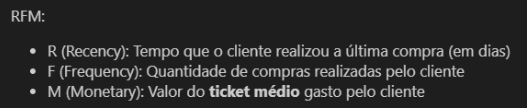

R --> recência:

tempo atual - tempo da última compra em dias. O x.max é a última data, porém tem que pegar a data que teve transação

In [ ]:
#tempo atual
pd.Timestamp.today()

Timestamp('2023-04-04 13:24:15.672463')

Descobrir qual foi a última data que houve a transação

In [ ]:
# 1. Filtro para as linhas onde o status é ativo
df_ativos = df_lojista[df_lojista['rec_status'] == 'ativo']

In [ ]:
# 2. Agrupando por id e selecionando a data máxima em que o status esteve ativo
recencia = df_ativos.groupby('rec_est_id')['rec_month'].max().reset_index()

In [ ]:
# 3. Subtraindo a data máxima pela data atual para obter a diferença em dias
recencia['diff_days'] = (datetime.today() - recencia['rec_month']).dt.days

In [ ]:
# 4. Convertendo a diferença em dias para meses
recencia['diff_months'] = recencia['diff_days'] // 30

Posta a data da última transação a partir do dia de hoje

Se verifica a recência em dias ou meses

In [ ]:
recencia

,rec_est_id,rec_month,diff_days,diff_months
0,1,2023-02-01,62,2
1,49,2023-01-01,93,3
2,89,2022-03-01,399,13
3,109,2023-02-01,62,2
4,112,2022-04-01,368,12
...,...,...,...,...
5625,30481,2023-02-01,62,2
5626,30484,2023-02-01,62,2
5627,30503,2023-02-01,62,2
5628,30504,2023-02-01,62,2


F --> frequência se calcula verificando quantos itens foi comprado no total ou quantos pedidos foi solicitado no total. Depende da estratégia que se queira usar.
Verificar quantos pedidos únicos foram feitos. Lembrando que pedido para cada produto pode ter múltiplos produtos com múltiplas quantidades;

In [ ]:
# criando um novo dataframe apenas com os ids e a contagem de ids para o status ativo
frequencia = df_lojista[df_lojista['rec_status'] == 'ativo'].groupby('rec_est_id').size().reset_index(name='F')


In [ ]:
frequencia

,rec_est_id,F
0,1,13
1,49,4
2,89,3
3,109,1
4,112,4
...,...,...
5625,30481,1
5626,30484,1
5627,30503,1
5628,30504,1


M --> monetary

Descobre pelo ticket Médio preço total ou a média

In [ ]:
# Agrupa os valores por mês e calcula a média dos valores de "fatura" maiores que zero
monetary = df_lojista[df_lojista['rec_month_mf'] > 0].groupby(df_lojista['rec_est_id'])['rec_month_mf'].mean()


Passando para o formato de dataframe

In [ ]:
monetary = monetary.to_frame()

In [ ]:
monetary

,rec_month_mf
rec_est_id,
1,14997.765385
49,238.675000
89,3736.666667
109,5.500000
112,9025.800000
...,...
30481,5.000000
30484,0.100000
30503,110.000000


Unindo as três tabelas através do id

In [ ]:
# Unindo as tabelas pela direita, usando a coluna 'id' como chave
df_resultado = pd.merge(recencia, frequencia, on='rec_est_id', how='right')
df_resultado = pd.merge(df_resultado, monetary, on='rec_est_id', how='right')

In [ ]:
df_resultado

,rec_est_id,rec_month,diff_days,diff_months,F,rec_month_mf
0,1,2023-02-01,62,2,13,14997.765385
1,49,2023-01-01,93,3,4,238.675000
2,89,2022-03-01,399,13,3,3736.666667
3,109,2023-02-01,62,2,1,5.500000
4,112,2022-04-01,368,12,4,9025.800000
...,...,...,...,...,...,...
5625,30481,2023-02-01,62,2,1,5.000000
5626,30484,2023-02-01,62,2,1,0.100000
5627,30503,2023-02-01,62,2,1,110.000000
5628,30504,2023-02-01,62,2,1,0.010000


Excluindo duas colunas

In [ ]:
df_resultado = df_resultado.drop(columns=['rec_month', 'diff_months'], axis=1)


In [ ]:
df_resultado

,rec_est_id,diff_days,F,rec_month_mf
0,1,62,13,14997.765385
1,49,93,4,238.675000
2,89,399,3,3736.666667
3,109,62,1,5.500000
4,112,368,4,9025.800000
...,...,...,...,...
5625,30481,62,1,5.000000
5626,30484,62,1,0.100000
5627,30503,62,1,110.000000
5628,30504,62,1,0.010000


In [ ]:
# renomear as colunas
df_resultado = df_resultado.rename(columns={'rec_est_id': 'ID', 'diff_days': 'R', 'F': 'F', 'rec_month_mf': 'M'})


In [ ]:
df_resultado

,ID,R,F,M
0,1,62,13,14997.765385
1,49,93,4,238.675000
2,89,399,3,3736.666667
3,109,62,1,5.500000
4,112,368,4,9025.800000
...,...,...,...,...
5625,30481,62,1,5.000000
5626,30484,62,1,0.100000
5627,30503,62,1,110.000000
5628,30504,62,1,0.010000


Vou criar uma novo dataframe que vai receber dropar a coluna do ID. Não exclui ela antes porque em algum momento vou ter que apresentar resultados

In [ ]:
df_clustering = df_resultado.drop(columns=['ID'], axis=1)

In [ ]:
df_clustering

,R,F,M
0,62,13,14997.765385
1,93,4,238.675000
2,399,3,3736.666667
3,62,1,5.500000
4,368,4,9025.800000
...,...,...,...
5625,62,1,5.000000
5626,62,1,0.100000
5627,62,1,110.000000
5628,62,1,0.010000


Como estão em escalas diferentes ficam com valores diferentes vou escalonar usando scale

In [ ]:
# Realizando uma normalização dos dados através da função PowerTransformer
df_clustering2 = df_clustering.copy()
scaler = PowerTransformer()
df_clustering = pd.DataFrame(scaler.fit_transform(df_clustering), index=df_clustering.index, columns=df_clustering.columns)
df_clustering

,R,F,M
0,-1.240434,1.797676,1.112115
1,-0.894564,0.671074,-0.843770
2,0.898608,0.315326,0.325924
3,-1.240434,-1.168036,-1.833867
4,0.770967,0.671074,0.806989
...,...,...,...
5625,-1.240434,-1.168036,-1.850671
5626,-1.240434,-1.168036,-2.166006
5627,-1.240434,-1.168036,-1.098744
5628,-1.240434,-1.168036,-2.179984


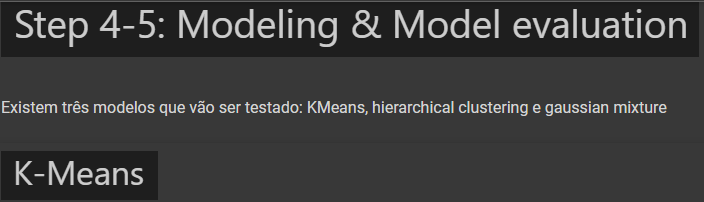

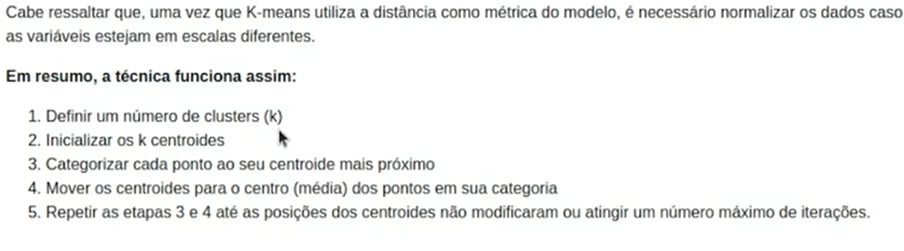

Para a etapa 1, existem quatro formas de se definir um número de clusters (k), são elas:

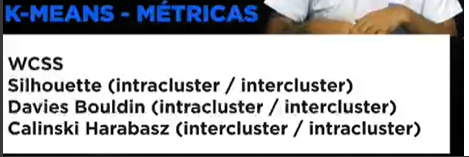

Agora vou fazer uma lista de dicionários com todos os coeficientes de métricas que estamos avaliando para verificar quais dessas métricas se adequa melhor a essa questão:

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score --> tupla com métricas

cluster_metrics_results = [] --> lista vazia

Para cada k de 2 a 10 vou criar e rodar o modelo, vou gerar os labels, vou criar um dicionário e vou colocar a chave e o valor dentro da lista nula.
Na primeira interação k=2, vou colocar outra chave que vai ser inertia. Vou colocar outro loop pra poder fazer isso em todas as métricas

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(df_clustering)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(df_clustering, labels)
  cluster_metrics_results.append(cluster_results_dict)

cluster_metrics_results

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

[{'k': 2,
  'inertia': 8344.127348020706,
  'silhouette_score': 0.4526884491914244,
  'davies_bouldin_score': 0.8801702183765935,
  'calinski_harabasz_score': 5764.1009493886995},
 {'k': 3,
  'inertia': 6379.035059849277,
  'silhouette_score': 0.38036948446685465,
  'davies_bouldin_score': 1.0756478762996404,
  'calinski_harabasz_score': 4636.015556532109},
 {'k': 4,
  'inertia': 5255.334978373783,
  'silhouette_score': 0.3281064270935775,
  'davies_bouldin_score': 1.1294843538090829,
  'calinski_harabasz_score': 4151.803333712122},
 {'k': 5,
  'inertia': 4372.309548619903,
  'silhouette_score': 0.3518545370993731,
  'davies_bouldin_score': 1.0227035773280926,
  'calinski_harabasz_score': 4026.0383912830507},
 {'k': 6,
  'inertia': 3748.6167041191984,
  'silhouette_score': 0.3458346149129124,
  'davies_bouldin_score': 0.9792351768377295,
  'calinski_harabasz_score': 3943.185208173513},
 {'k': 7,
  'inertia': 3264.6159249610328,
  'silhouette_score': 0.3369181383758344,
  'davies_bouldi

Analisando a tabela abaixo:

1- inertia: melhor é quanto mais próximo de 1;

2- silhouette_score: melhor é quanto mais próximo de 1;

3- davies_bouldin_score: é o contrário das outras métricas, nela quanto mais distante de 1 melhor;

4- calinski_harabasz_score: melhor é quanto mais próximo de 1;

Geralmente a mais usada é a silhouette

In [ ]:
# Create dataframe
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8344.127348,0.452688,0.880170,5764.100949
3,6379.035060,0.380369,1.075648,4636.015557
4,5255.334978,0.328106,1.129484,4151.803334
5,4372.309549,0.351855,1.022704,4026.038391
6,3748.616704,0.345835,0.979235,3943.185208
7,3264.615925,0.336918,0.949513,3911.435704
8,2905.022865,0.348584,0.943919,3866.695302
9,2615.030441,0.355298,0.925261,3835.568948
10,2364.066265,0.349381,0.940017,3836.929578


A inércia é quando a curva do gráfico do cotovelo começa a estabilizar, analisando os dados da tabela acima, vemos que isso ocorre quando k = 6, porém pra outras métricas é ideal outro valor de k.

Pra o silhouette o indicado é pra k = 2, porém é bom se trabalhar com mais clustering, até k = 10 é um bom indicativo, pois está acima de 0.5;

davies_bouldin é o contrário das demais métricas, quanto mais próximo de zero melhor. O melhor é pra k = 6

calinski precisa ser feita a normalização dos dados

Para segmentar clientes por RFV: Recência, Frequência e Valor, é mais indicado utilizar k = 10, como mostra figura abaixo:

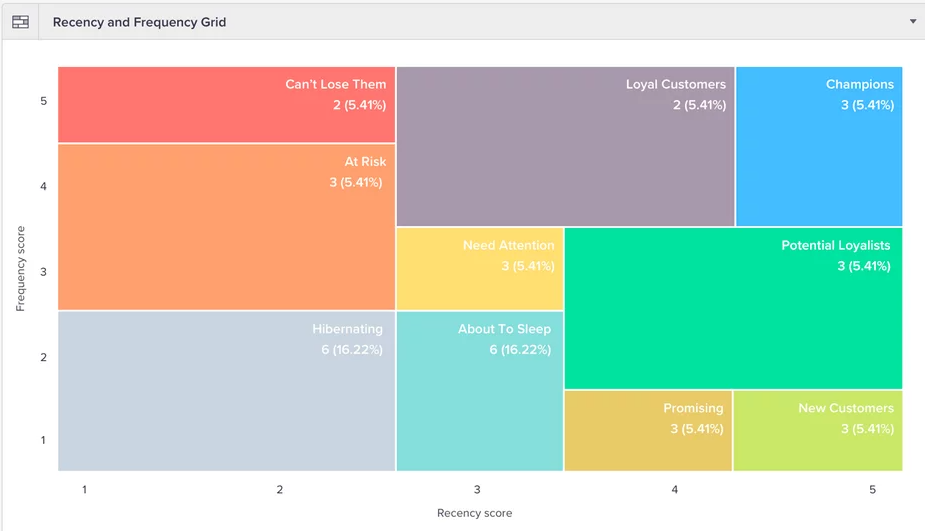

Apesar de em nenhuma das métricas k = 10 ser o ideal, mas em nenhuma das métricas o modelo fica prejudicado então para definir melhor os clusters, iremos utilizar k = 10

Aplicando K-Means:

A maioria dos métodos aplicados são para variáveis contínuas. As principais métricas para medidas de distâncias (dissimilaridade) utilizadas são:

1- Euclidiana; 2- Quadrática Euclidiana; 3- Minkowski; 4- manhattan; 5- Chebychev; 6- Canberra

Vamos instalar a biblioteca Kmodes, ela é similar ao K means, porém ela é específica para dados categóricos.

In [ ]:
%%capture
%pip install kmodes

Quase todas as bibliotecas já estão no inicio do programa

De scipy

In [ ]:
from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

Agora vamos aplicar o Kmeans. No sklearn, podemos utilizar algoritmos de clusterização através de classes ou funções.

In [ ]:
# Usando função
# centroids, labels, intertia = k_means(df_clustering, n_clusters=10)

Características:

1- mais utilizado na indústria;

2- requer uma pré-especificação da quantidade de grupos (K). 

Caso as variáveis estejam na mesma escala não precisa fazer uma escalonização, do contrário sim.

Precisa informar ao modelo quantos grupos são necessários colocar nas observações, nesse caso escolhi k = 10

Plotando pra saber como está a distribuição dos clustering, lembrando que x, y são as colunas que eu comparar que é R F M, posso ir compararndo duas em duas:

<ipython-input-407-76614ca6d6ac>:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



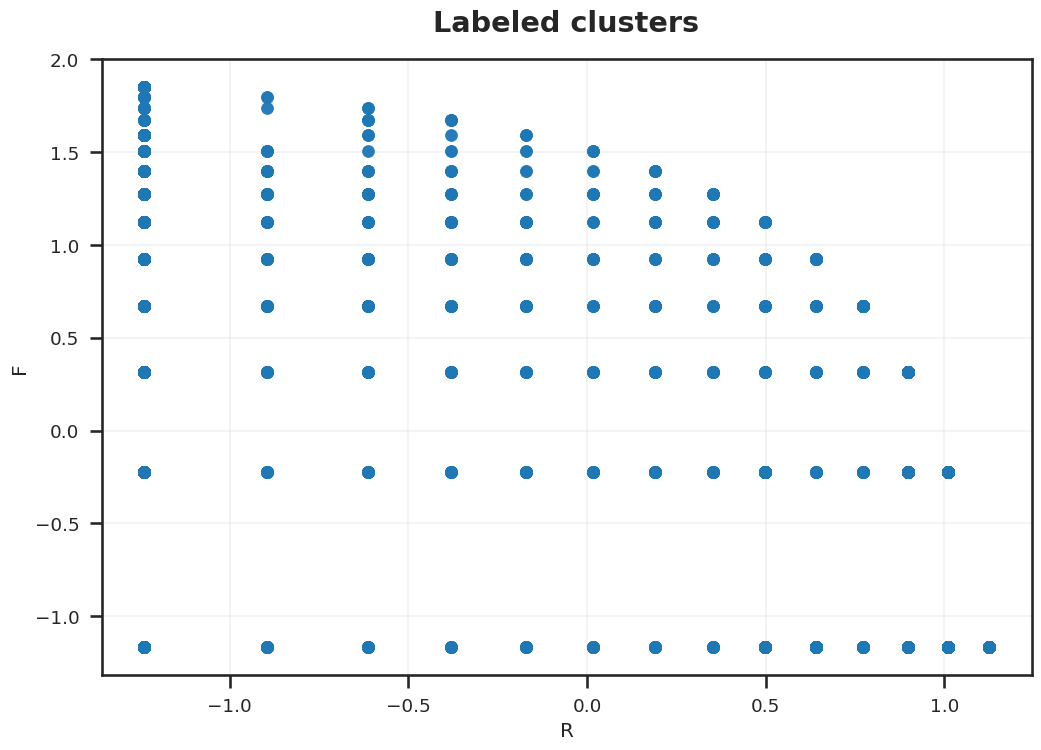

In [ ]:
# Visualize Distribuição da relação de R x F
sns.scatterplot(data=df_clustering, x='R', y='F', **scatter_kwargs)
plt.title('Labeled clusters')
plt.show()

No caso do gráfico acima, apesar de ter dados negativos pro R na tabela após a normalização, só está sendo mostrado os valores positivos

<ipython-input-408-92e44d551e42>:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



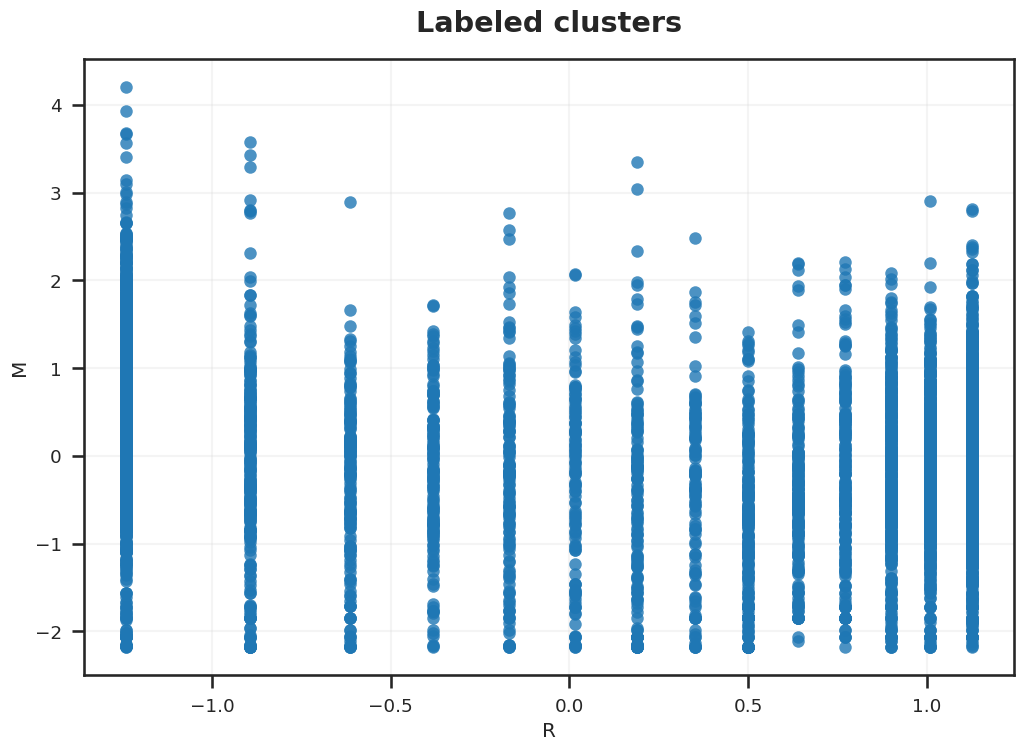

In [ ]:
# Visualize Distribuição da relação de R x M
sns.scatterplot(data=df_clustering, x='R', y='M', **scatter_kwargs)
plt.title('Labeled clusters')
plt.show()

<ipython-input-409-4ed64e610b63>:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



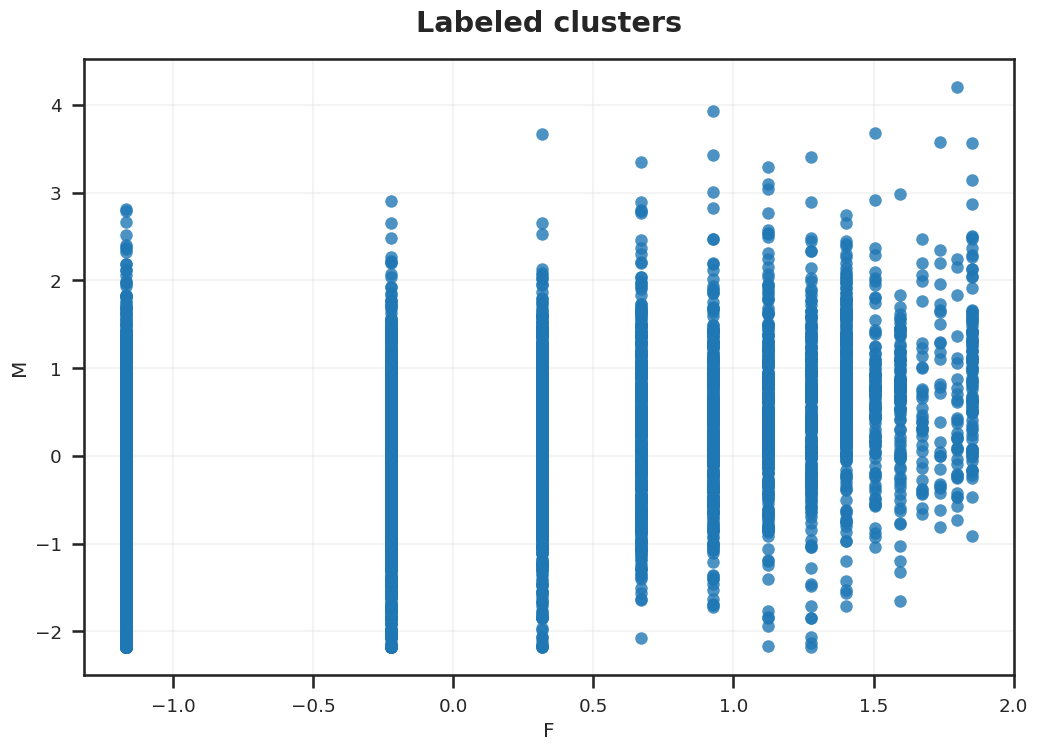

In [ ]:
# Visualize Distribuição da relação de R x F
sns.scatterplot(data=df_clustering, x='F', y='M', **scatter_kwargs)
plt.title('Labeled clusters')
plt.show()

Por Classes

A diferença entre classes e funções é que a classe vai ser utilizada em pipelines

Estou criando centróide, rótulos..ect, que vão fazer parte dos 10 clustering que também estão sendo criando nesse código abaixo:

In [ ]:
# Using KMeans
model = KMeans(n_clusters=10, random_state = 0)
model.fit(df_clustering)

centroids = model.cluster_centers_
labels = model.labels_
inertia = model.inertia_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Podemos fazer um gráfico 3D, já que são 3 variáveis:

In [ ]:
# 3D PCA plot
px.scatter_3d(df_clustering, x='R', y='F', z='M', color=labels, template='plotly_dark')

In [ ]:
(
df_clustering.assign(cluster=labels).groupby('cluster')
.mean()
.style.background_gradient(cmap='YlOrRd')
)

,R,F,M
cluster,,,
0,1.013630,-1.168036,-0.439452
1,-1.137909,1.130262,1.665859
2,0.694376,-0.997690,-1.710632
3,-0.753946,0.949615,-0.534023
4,0.743165,0.191818,0.676610
5,1.063186,-1.168036,0.726113
6,-1.089874,-0.335106,0.334788
7,-0.815715,-0.711351,-1.473066
8,-1.138229,1.254419,0.558529


Grupo 1 - Não podem perdê-los -

(Lojistas quase perdidos com baixa frequência e faturamento altos) :

In [ ]:
#Recência: 4
#Frequência: 1
#Faturamento Mensal Médio: 3

Grupo 1 - Campeões -

(Lojistas ativos com frequência e faturamento muito altos):

In [ ]:
#Recência: 1
#Frequência: 4 
#Faturamento Mensal Médio: 5

Grupo 2 - Prestes a churn -

(Lojistas quase perdidos com frequência e faturamento baixos):

In [ ]:
#Recência: 4
#Frequência: 1
#Faturamento Mensal Médio: 1

Grupo 3 - Não podem perdê-los -

(Lojistas ativos com frequência e faturamento baixo):

In [ ]:
#Recência: 2
#Frequência: 4
#Faturamento Mensal Médio: 2

Grupo 4 - Não podem perdê-los -

(Lojistas quase perdidos com frequência e faturamento regular) :

In [ ]:
#Recência: 4
#Frequência: 3
#Faturamento Mensal Médio: 3

Grupo 5 - Churns com pouco potencial -

(Lojistas perdidos com baixa frequência e regular faturamento:

In [ ]:
#Recência: 5
#Frequência: 1 
#Faturamento Mensal Médio: 3

Grupo 6 - Promessas -

(Lojistas Recentes com regular faturamente e potencial):

In [ ]:
#Recência: 1
#Frequência: 2
#Faturamento Mensal Médio: 3

Grupo 7 - Potenciais -

(Lojistas ativos com alta frequência e baixo faturamento):

In [ ]:
#Recência: 2
#Frequência: 2 
#Faturamento Mensal Médio: 1

Grupo 8 - Leais -

(Lojistas ativos com frequência muito alta e com alto faturamento):

In [ ]:
#Recência: 1
#Frequência: 5 
#Faturamento Mensal Médio: 3

Grupo 9 - Precisam de atenção -

(Lojistas quase perdidos com alta frequência e regular faturamento ):

In [ ]:
#Recência: 4
#Frequência: 3
#Faturamento Mensal Médio: 2

In [ ]:
labels

array([8, 3, 4, ..., 7, 7, 7], dtype=int32)

Criar uma coluna que diz em qual grupo cada ID pertence

In [ ]:
grupos = pd.DataFrame(labels, columns = ['rec_grupo'])

In [ ]:
grupos.value_counts()

rec_grupo
8            912
0            766
9            751
4            596
2            488
6            477
5            473
1            465
3            461
7            241
dtype: int64

Monstrando o dataset original, ou seja, antes de ser normalizado

In [ ]:
df_clustering2.head(20)

,R,F,M
0,62,13,14997.765385
1,93,4,238.675000
2,399,3,3736.666667
3,62,1,5.500000
4,368,4,9025.800000
5,62,14,11541.937143
6,368,4,6856.500000
7,154,11,8051.516364
8,458,1,10681.000000
9,399,2,1642.100000


In [ ]:
# juntar
df_resultado = df_clustering2.merge(grupos, how='inner', left_index=True, right_index=True)

df_resultado.head(20)

,R,F,M,rec_grupo
0,62,13,14997.765385,8
1,93,4,238.675000,3
2,399,3,3736.666667,4
3,62,1,5.500000,7
4,368,4,9025.800000,4
5,62,14,11541.937143,8
6,368,4,6856.500000,4
7,154,11,8051.516364,8
8,458,1,10681.000000,5
9,399,2,1642.100000,9


Do grupo 3 verificando as frequências por IDs

In [ ]:
df_resultado[df_resultado['rec_grupo']== 3].F.value_counts()

4     100
5      88
3      75
6      61
7      55
8      28
10     18
9      16
11      7
12      6
13      5
14      2
Name: F, dtype: int64

# 4.3.  Cluster Hierárquico

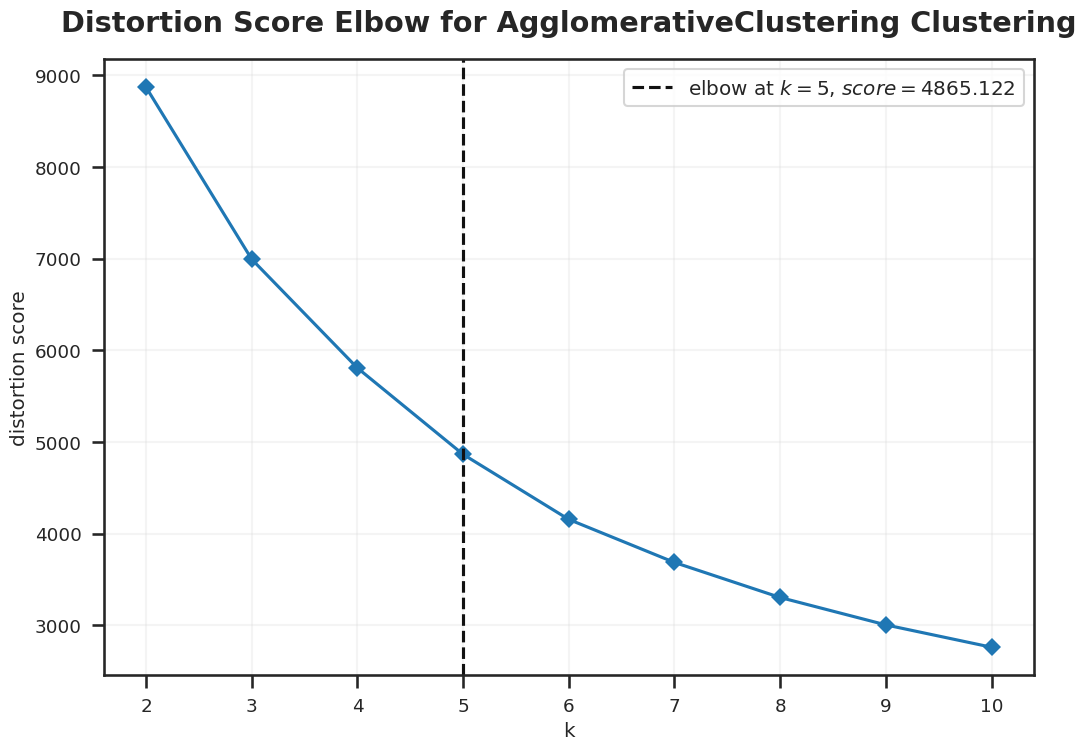

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
kelbow_visualizer(AgglomerativeClustering(), df_clustering, k=10, timings=False)

In [ ]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_clustering.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}

  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.433730,0.918481,5088.875646
3,0.376689,1.008119,3981.746115
4,0.361080,0.999933,3578.818980
5,0.351157,1.012852,3475.757083
6,0.317187,1.015958,3446.750091
7,0.312145,1.039384,3356.712456
8,0.304122,1.005697,3302.318869
9,0.308863,1.018706,3246.181865
10,0.296673,1.041960,3194.618658


In [ ]:
hclust = AgglomerativeClustering(n_clusters=10)
hclust_labels = hclust.fit_predict(df_clustering)

In [ ]:
px.scatter_3d(df_clustering, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

In [ ]:
(
df_clustering.assign(cluster=hclust_labels).groupby('cluster')
.mean()
.style.background_gradient(cmap='YlOrRd')
)

,R,F,M
cluster,,,
0,-0.346257,-0.552277,-1.489532
1,0.733945,0.134495,0.619387
2,-1.211329,1.148604,1.411848
3,-1.045783,1.135865,0.320361
4,-1.015700,-0.565971,0.312029
5,1.037604,-1.168036,-0.352406
6,0.739423,0.154493,-0.549831
7,1.114698,-1.168036,0.909666
8,0.736257,-1.168036,-1.735856


#4.4. Gaussian Mixture

In [ ]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_clustering.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
28,-35532.527141,8,full
30,-32107.111266,8,diag
26,-29806.861187,7,diag
22,-29486.067081,6,diag
20,-19188.872769,6,full


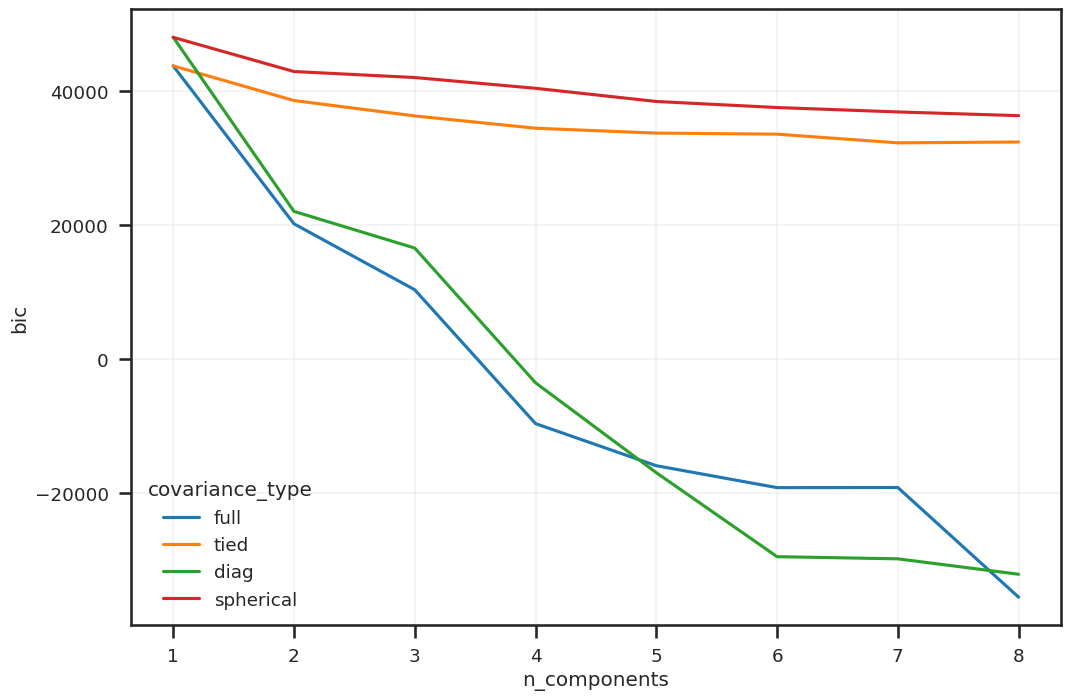

In [ ]:
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_clustering)

In [ ]:
mclust = GaussianMixture(n_components=10, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_clustering)

In [ ]:
px.scatter_3d(df_clustering, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

Visualmente, pode-se perceber que os modelos de cluster Hierárquico e Gaussian Mixture possuem mais dispersões e maior desvio padrão em seus grupos, portanto o autor irá preferir optar pelo modelo K-means, caso o DBSCAN também não consiga fornecer bons resultados.

# 4.5. DBSCAN

In [ ]:
# Determinando o parâmetros eps através dos NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

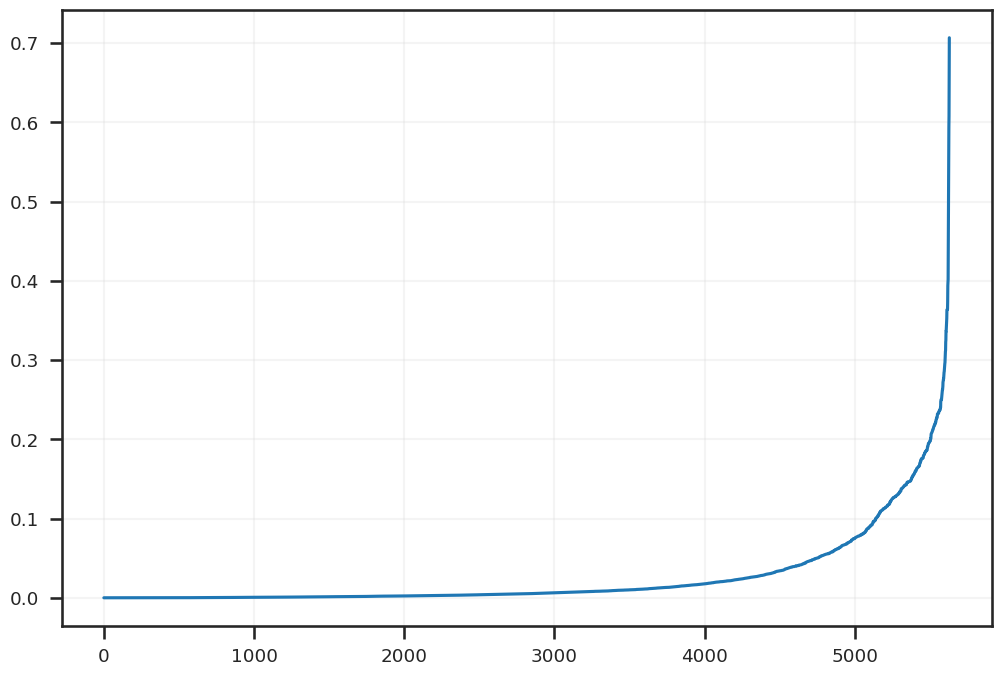

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
m = DBSCAN(eps=0.3, min_samples=3)
m.fit(X)

DBSCAN(eps=0.3, min_samples=3)

In [ ]:
clusters = m.labels_

In [ ]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

In [ ]:
px.scatter_3d(df_clustering, x='R', y='F', z='M', color=clusters, template='plotly_dark')

Percebe-se que o DBSCAN para essa massa de dados também não explica tão bem quanto o K-means o comportamento dos lojistas, sejam eles recorrentes, iminentes de saída ou churns. Essa observação se deve ao fato de que a dispersão dos dados em relação aos centróides é maior do que a dos outros modelos, principalmente a do K-means.

# 5. Análises de cada grupo

In [ ]:
# Análise descritiva dos dados de acordo com as classificações.

for i in range (0,9):
  print('')
  print(f'Grupo {i}')
  print('')
  print('Recência')
  print(df_resultado[df_resultado['rec_grupo']==i].R.value_counts())
  print('')
  print('Frequência')
  print(df_resultado[df_resultado['rec_grupo']==i].F.value_counts())
  print('')
  print('Ticket Médio')
  print(df_resultado[df_resultado['rec_grupo']==i].M.describe())
  print('')


Grupo 0

Recência
458    551
338     76
427     60
399     29
368     16
307     12
215      9
246      6
277      5
185      2
Name: R, dtype: int64

Frequência
1    766
Name: F, dtype: int64

Ticket Médio
count     766.000000
mean      903.000574
std       655.206835
min        92.500000
25%       369.932500
50%       705.505000
75%      1330.327500
max      2680.000000
Name: M, dtype: float64


Grupo 1

Recência
62     405
93      23
154     11
246      8
185      7
124      5
215      4
277      2
Name: R, dtype: int64

Frequência
8     94
4     60
6     51
7     49
5     48
3     46
14    41
10    21
9     19
2     13
12    11
11     7
13     5
Name: F, dtype: int64

Ticket Médio
count       465.000000
mean      46806.632031
std       61074.291091
min       13861.550000
25%       19939.838333
50%       27334.650000
75%       45903.806667
max      650805.612308
Name: M, dtype: float64


Grupo 2

Recência
458    107
307    104
427     51
399     49
246     46
368     38
338     38


Basicamente, o cluster gerado reproduz subcategorias relacionadas à clientes frequentemente ativos, clientes churns e clientes na iminência de churn. E esses clusters conseguem explicar bem o comportamento geral dos lojistas. Portanto, o modelo K-means consegue ser um modelo eficiente para o conjunto de dados que foi adaptado, preparado e treinado.

# # 6. Classificando os dados com o modelo KNN # 

Será validado se, ao aplicar o modelo supervisionado KNN no dataset gerado para clusterização, ele conseguirá predizer bem possíveis dados futuros que estarão no banco de dados.

In [ ]:
df_clustering_classificacao = df_clustering.merge(grupos, how='inner', left_index=True, right_index=True)
df_clustering_classificacao 

,R,F,M,rec_grupo
0,-1.240434,1.797676,1.112115,8
1,-0.894564,0.671074,-0.843770,3
2,0.898608,0.315326,0.325924,4
3,-1.240434,-1.168036,-1.833867,7
4,0.770967,0.671074,0.806989,4
...,...,...,...,...
5625,-1.240434,-1.168036,-1.850671,7
5626,-1.240434,-1.168036,-2.166006,7
5627,-1.240434,-1.168036,-1.098744,7
5628,-1.240434,-1.168036,-2.179984,7


In [ ]:
X = df_clustering_classificacao.drop(columns='rec_grupo')
y = df_clustering_classificacao['rec_grupo']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state = 1)
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)

In [ ]:
result1 = classification_report(y_test, ypred)
print('Classification Report: ',)
print (result1)
result2 = accuracy_score(y_test,ypred)
print('Accuracy:',round(100*result2, 2))

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       193
           1       1.00      0.93      0.96       123
           2       0.98      0.99      0.98       125
           3       0.93      0.95      0.94       104
           4       0.96      0.98      0.97       152
           5       0.99      1.00      1.00       120
           6       0.96      0.96      0.96       124
           7       0.93      0.93      0.93        61
           8       0.95      0.97      0.96       221
           9       0.98      0.97      0.98       185

    accuracy                           0.97      1408
   macro avg       0.97      0.97      0.97      1408
weighted avg       0.97      0.97      0.97      1408

Accuracy: 97.09


# # 7. Gerando excel de entrega # #

In [ ]:
df_resultado = df_resultado[['ID',	'R',	'F',	'M', 'rec_grupo']]

KeyError: ignored

In [ ]:
df_resultado.rename(columns = {'R': 'rec_recência',  'F':'rec_frequência_ativo', 'M': 'rec_faturamento_médio', 'S':'rec_faturamento_total'}, inplace=True)

In [ ]:
df_resultado

,rec_recência,rec_frequência_ativo,rec_faturamento_médio,rec_grupo
0,62,13,14997.765385,8
1,93,4,238.675000,3
2,399,3,3736.666667,4
3,62,1,5.500000,7
4,368,4,9025.800000,4
...,...,...,...,...
5625,62,1,5.000000,7
5626,62,1,0.100000,7
5627,62,1,110.000000,7
5628,62,1,0.010000,7


In [ ]:
df_resultado.to_excel('resultado_clusterizacao.xlsx', index = False)